# General Approach and Requirements

The highest scoring model with the smallest required hardware to train and run was the FPN2 model [A11], MMN [A9] or MFaster-RCNN[A.14]. These all required a GTX 1080 TI, which can actually be run on a few froup member's hardware. I will be experimenting with the MFaster-RCNN detection architecture with an FPN integrated to handle the different scales of objects. 

# MFaster-RCNN with FPN2
Following are the packages that we need for the MFaster architecture with an FPN2

In [ ]:
# export CUDA_LAUNCH_BLOCKING=1
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import COCOeval

# Capture the Dataset for Preprocessing
Read in all of the image files into a list, as well as their corresponding annotations. The dataset also has a getter for the lenght of the dataset for iterative purposes later along with a getitem function for 

In [17]:
class VisDroneDataset(Dataset):
    def __init__(self, root_dir, annotation_dir, transforms=None):
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.image_files = sorted(os.listdir(root_dir))
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)
        annotation_name = img_name.replace('.jpg', '.txt')
        annotation_path = os.path.join(self.annotation_dir, annotation_name)

        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        
        with open(annotation_path, 'r') as f:
            for line in f:
                data = list(map(int, line.strip().split(',')[:8])) # Assuming standard VisDrone annotation format
                x_min, y_min, width, height = data[:4]
                x_max = x_min + width
                y_max = y_min + height
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(data[5]) # Assuming the 6th value is the class label
    

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['image_id'] = torch.tensor([idx])
        # target['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if boxes.numel() > 0 else torch.empty((0,), dtype=torch.float32)
        # target['iscrowd'] = torch.zeros((boxes.shape[0],), dtype=torch.int64) if boxes.numel() > 0 else torch.empty((0,), dtype=torch.int64)

        # initW = img.width
        # initH = img.height

        if self.transforms:
            img = self.transforms(img)
            # newW = img.width
            # newH = img.height
            
            # if initW != newW or initH != newH and target['boxes'].numel() > 0:
            #     scaleX = newW/initW
            #     scaleY = newH/initH
                
            #     boxes = target['boxes'] * torch.tensor([scaleX, scaleY, scaleX, scaleY])
            #     target['boxes'] = boxes.clamp(min=0)

        return img, target

# Data Augmentation
Resize and normalize the dataset with flips and scaling.

In [13]:
def get_transform(trainingImage):
    transforms = []
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    if trainingImage:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
    

# Load the dataset with dataloaders
Create custom dataset with the augmented data appended to the original dataset using the data loaders from before.

In [4]:
# Define paths to your training and testing data and annotations
train_img_dir = 'VisDrone2019-DET-train/images'
train_anno_dir = 'VisDrone2019-DET-train/annotations'
test_img_dir = 'images' # Using val set for testing example
test_anno_dir = 'annotations'

train_dataset = VisDroneDataset(train_img_dir, train_anno_dir, transforms=get_transform(True))
test_dataset = VisDroneDataset(test_img_dir, test_anno_dir, transforms=get_transform(False))

# Define a mapping from your dataset's class labels to the model's expected labels (starting from 1)
# You'll need to adjust this based on the VisDrone class categories
class_names = ['background', 'pedestrian', 'people', 'car', 'van', 'bus', 'truck', 'motorcycle', 'bicycle', 'awning-tricycle', 'tricycle']
num_classes = len(class_names)

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

# Define the model
Load in the MFaster R_CNN Model with FPN. I'm using the pre built fasterrcnn_resnet50_fpn from the torchvision models library. The number of classes is being set to 10, as the dataset has 10 objects that it can identify.

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # Start with pre-trained weights
numClasses = 10
inFeatures = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(inFeatures, numClasses)

model.eval().to(device)

/home/tow73/COMP9444/VisDroneInterpretaion/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tow73/COMP9444/VisDroneInterpretaion/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Running Inference on a Sample of Images
Here we take a portion of the images to posttrain the model that has already been pretrained on the COCO dataset. 

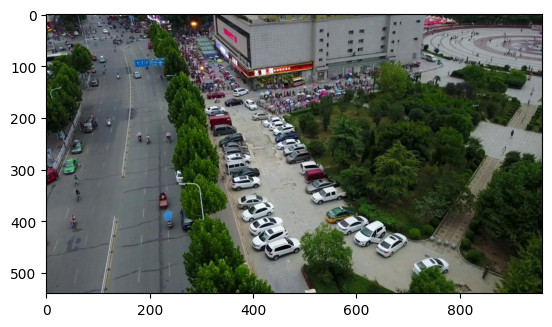

In [19]:
sampleSet = VisDroneDataset("VisDrone2019-DET-train/images", "VisDrone2019-DET-train/annotations", transforms=T.ToTensor())

img, target = sampleSet[0]

# Run the inference of the sample image
with torch.no_grad():
    prediction = model([img])
    
# Show trhe results
fig, ax = plt.subplots(1)
ax.imshow(F.to_pil_image(img))

for box, score in zip(prediction[0]['boxes'], prediction[0]['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
plt.show()


# Training on Sample Set
Using the sample set from before, we can train the model on the given visdrone dataset on top of the pretrained COCO dataset.

In [ ]:
img = img.to(device)

with torch.no_grad():
    prediction = model([img])[0]

# plot the picture    
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
imgNumpy = img.permute(1, 2, 0).cpu().numpy
ax.imshow(imgNumpy)

# Draw the prediction boxes
for box, score in zip(prediction['boxes'], prediction['scores']):
    if score > 0.5:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((float(x1), float(y1)), float(x2-x1), float(y2-y1), linewidth=2, edgecolor='r', facecolor='none'))
        
        ax.add_patch(rect)
        
plt.show()


# Evaluate with COCO Metrics
The metrics used to evaluate the results of the papers submitted in 2019 were different thresholds of Average Precision and Avergae Recall.

In [ ]:
def convertToCOCO(dataset):
    coco = {
        "images": [],
        "annotations": [],
        "categories": [{"id": i+1, "name": str(i+1)} for i in range(10)]
    }
    
    annotationID = 1
    for i in range(len(dataset)):
        img, target = dataset[i]
        coco["images"].append({
            "id": i,
            "width": img.shape[2],
            "height": img.shape[1],
            "filename": f"{i:06}.jpg"
        })
        
        boxes = target["boxes"]
        labels = target["labels"]
        for j in range(len(boxes)):
            x1, y1, x2, y2 = boxes[j].tolist()
            coco["annotations"].append({
                "id": annotationID,
                "imageID": i,
                "categoryID": int(labels[j]),
                "bbox": [x1, y1, x2-x1, y2-y1],
                "area": (x2-x1) * (y2-y1),
                "isCrowded": 0
            })
            
            annotationID += 1
    
    return coco
        
# print the metric results to a json file
annotationJSON = "annotations.json"
predictJSON = "predictions.json"

cocoGT = COCO(annotationJSON)
cocoDT = COCO(predictJSON)

cocoEval = COCOeval(cocoGT, cocoDT, "bbox")
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

# Define Hyerparameters
Defining the optimizer and learning rates for training.

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.0001)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1) # Reduce LR every 3 epochs by a factor of 0.1

# Train the model
Implement the training loop with the data from the dataloader. Perform the forward and backward passes to update the model weights.

In [7]:
# all_labels = [label.item() for batch in train_dataloader for label in batch[1]['labels']]
# print(f"Min label: {min(all_labels)}, Max label: {max(all_labels)}")


num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        epoch_loss += loss_value

        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f"Epoch {epoch+1} Loss: {epoch_loss / len(train_dataloader)}")

# print("Training finished!")

Epoch 1/10:   0%|          | 0/809 [01:44<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Test with test set
Asses the performance of the model on a test set. Using mean average precision for evlaution metric.

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(test_dataloader, desc='Evaluating'):
        images = list(image.to(device) for image in images)
        outputs = model(images)

        # Process the outputs and targets to calculate evaluation metrics
        # This part will depend on the specific evaluation metrics you want to use
        # and might require converting the output format.
        # Example (simplified - you'll need more detailed processing):
        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            # Store these predictions and the corresponding ground truth targets

            # Example of storing (you'll need to adapt this):
            all_preds.append({'boxes': boxes, 'scores': scores, 'labels': labels})
            all_targets.append({'boxes': targets[i]['boxes'].cpu().numpy(), 'labels': targets[i]['labels'].cpu().numpy()})

# Calculate evaluation metrics (e.g., mAP) using all_preds and all_targets
# This often involves using libraries like pycocotools if your data format aligns with COCO.
print("Evaluation finished!")